## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [2]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

# 載入 optimizers
adam = keras.optimizers.Adam(lr=LEARNING_RATE)
rms = keras.optimizers.RMSprop(lr=LEARNING_RATE)

params = {'PATIENCE': [3,5,10], 
          'FACTOR': [0.2, 0.5, 0.7], 
          'OPTIMIZER': ['rms','adam']}

In [12]:
# 載入 Callbacks
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [13]:
from sklearn.model_selection import ParameterGrid
results = {}
"""
Write your training loop and record results
"""
for g in ParameterGrid(params):
    print('params: PATIENCE: {}, FACTOR: {}, OPTIMIZER: {}'.format(*g.values()))
    keras.backend.clear_session()
    model = build_mlp((x_train.shape[1],))
    model.summary()
    
    if g['OPTIMIZER'] == 'rms':
        optimizer = keras.optimizers.RMSprop(lr=LEARNING_RATE)
    else:
        optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    
    reduce_lr = ReduceLROnPlateau(factor=g['FACTOR'], 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=g['PATIENCE'], 
                              verbose=1)
    earlystop = EarlyStopping(patience=15, verbose = 1, mode = 'min')
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True, 
              callbacks = [earlystop, reduce_lr])

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-{}-{}-{}".format(*g.values())
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

params: PATIENCE: 0.2, FACTOR: rms, OPTIMIZER: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batc

Epoch 2/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.5373 - acc: 0.4575 - val_loss: 3.1678 - val_acc: 0.2002
Epoch 3/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.4305 - acc: 0.4943 - val_loss: 1.8268 - val_acc: 0.3583
Epoch 4/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.3584 - acc: 0.5212 - val_loss: 2.3694 - val_acc: 0.2505
Epoch 5/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.3029 - acc: 0.5403 - val_loss: 1.9324 - val_acc: 0.3467
Epoch 6/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.2502 - acc: 0.5583 - val_loss: 2.1323 - val_acc: 0.3281
Epoch 7/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.2055 - acc: 0.5761 - val_loss: 2.0779 - val_acc: 0.3150
Epoch 8/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.1606 - acc: 0.5901 - val_loss: 2.2071 - val_acc: 0.3330

Epoch 00008: ReduceLROnPlateau reducing 

50000/50000 [==============================] - 2s 41us/step - loss: 1.0911 - acc: 0.6145 - val_loss: 2.5246 - val_acc: 0.2727
Epoch 11/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.0568 - acc: 0.6272 - val_loss: 1.7027 - val_acc: 0.4141
Epoch 12/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.0189 - acc: 0.6399 - val_loss: 1.9245 - val_acc: 0.3639
Epoch 13/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9849 - acc: 0.6524 - val_loss: 1.7369 - val_acc: 0.3977
Epoch 14/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9598 - acc: 0.6605 - val_loss: 2.0387 - val_acc: 0.3708
Epoch 15/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.9251 - acc: 0.6715 - val_loss: 1.6624 - val_acc: 0.4468
Epoch 16/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.8957 - acc: 0.6841 - val_loss: 1.9011 - val_acc: 0.4011
Epoch 17/50
50000/50000 [=====================

50000/50000 [==============================] - 2s 41us/step - loss: 0.8600 - acc: 0.7075 - val_loss: 1.4251 - val_acc: 0.5117

Epoch 00015: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 16/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.8076 - acc: 0.7321 - val_loss: 1.3340 - val_acc: 0.5393
Epoch 17/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.7919 - acc: 0.7392 - val_loss: 1.3500 - val_acc: 0.5363
Epoch 18/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.7832 - acc: 0.7420 - val_loss: 1.3377 - val_acc: 0.5449
Epoch 19/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.7765 - acc: 0.7452 - val_loss: 1.3372 - val_acc: 0.5417

Epoch 00019: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 20/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.7639 - acc: 0.7493 - val_loss: 1.3310 - val_acc: 0.5448
Epoch 21/50
50000/500

Epoch 23/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.5527 - acc: 0.8270 - val_loss: 1.4597 - val_acc: 0.5277
Epoch 24/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.5340 - acc: 0.8326 - val_loss: 1.4832 - val_acc: 0.5221
Epoch 25/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.5118 - acc: 0.8419 - val_loss: 1.5350 - val_acc: 0.5176

Epoch 00025: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
Epoch 26/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.4636 - acc: 0.8659 - val_loss: 1.4575 - val_acc: 0.5385
Epoch 27/50
50000/50000 [==============================] - 2s 43us/step - loss: 0.4501 - acc: 0.8722 - val_loss: 1.4564 - val_acc: 0.5382
Epoch 28/50
50000/50000 [==============================] - 2s 44us/step - loss: 0.4434 - acc: 0.8752 - val_loss: 1.4656 - val_acc: 0.5411
Epoch 29/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.4394 - a

50000/50000 [==============================] - 2s 42us/step - loss: 0.2795 - acc: 0.9375 - val_loss: 1.6545 - val_acc: 0.5307
Epoch 34/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.2744 - acc: 0.9388 - val_loss: 1.6560 - val_acc: 0.5290
Epoch 35/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.2710 - acc: 0.9402 - val_loss: 1.6708 - val_acc: 0.5295
Epoch 36/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.2681 - acc: 0.9411 - val_loss: 1.6800 - val_acc: 0.5283
Epoch 00036: early stopping
params: PATIENCE: 0.5, FACTOR: rms, OPTIMIZER: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_____________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.8036 - acc: 0.3742 - val_loss: 2.2232 - val_acc: 0.2926
Epoch 2/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.5333 - acc: 0.4587 - val_loss: 2.6070 - val_acc: 0.2770
Epoch 3/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.4272 - acc: 0.4956 - val_loss: 2.2021 - val_acc: 0.2651
Epoch 4/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.3514 - acc: 0.5224 - val_loss: 2.0418 - val_acc: 0.2886
Epoch 5/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.2999 - acc: 0.5390 - val_loss: 2.0189 - val_acc: 0.3132
Epoch 6/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.2474 - acc: 0.5581 - val_loss: 2.3298 - val_acc: 0.2986
Epoch 7/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.2090 - acc: 0.5717 - val_loss: 1.9666 - val_acc

Epoch 16/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.8904 - acc: 0.6858 - val_loss: 2.0866 - val_acc: 0.3879
Epoch 17/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.8626 - acc: 0.6965 - val_loss: 1.7704 - val_acc: 0.4077
Epoch 18/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.8335 - acc: 0.7074 - val_loss: 1.7939 - val_acc: 0.4295
Epoch 19/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.8071 - acc: 0.7176 - val_loss: 2.2924 - val_acc: 0.3639
Epoch 20/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.7800 - acc: 0.7262 - val_loss: 1.9369 - val_acc: 0.4135
Epoch 21/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.7459 - acc: 0.7406 - val_loss: 2.1789 - val_acc: 0.3918
Epoch 22/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.7282 - acc: 0.7451 - val_loss: 1.7733 - val_acc: 0.4583
Epoch 23/50
50000/50000 [=========

Epoch 31/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.3484 - acc: 0.9155 - val_loss: 1.5624 - val_acc: 0.5276

Epoch 00031: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 32/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.3422 - acc: 0.9190 - val_loss: 1.5630 - val_acc: 0.5265
Epoch 33/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.3405 - acc: 0.9182 - val_loss: 1.5708 - val_acc: 0.5280
Epoch 34/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.3385 - acc: 0.9193 - val_loss: 1.5708 - val_acc: 0.5272

Epoch 00034: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 00034: early stopping
params: PATIENCE: 0.5, FACTOR: adam, OPTIMIZER: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________

50000/50000 [==============================] - 3s 66us/step - loss: 1.7717 - acc: 0.3847 - val_loss: 1.7363 - val_acc: 0.3902
Epoch 2/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.5038 - acc: 0.4710 - val_loss: 2.1125 - val_acc: 0.3099
Epoch 3/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.4063 - acc: 0.5032 - val_loss: 2.1962 - val_acc: 0.3039
Epoch 4/50
50000/50000 [==============================] - 2s 43us/step - loss: 1.3271 - acc: 0.5328 - val_loss: 1.9363 - val_acc: 0.3507
Epoch 5/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.2605 - acc: 0.5544 - val_loss: 2.0771 - val_acc: 0.3360
Epoch 6/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.2040 - acc: 0.5768 - val_loss: 1.8301 - val_acc: 0.3862
Epoch 7/50
50000/50000 [==============================] - 2s 41us/step - loss: 1.1461 - acc: 0.5989 - val_loss: 1.8311 - val_acc: 0.3985
Epoch 8/50
50000/50000 [============================

50000/50000 [==============================] - 2s 41us/step - loss: 0.7662 - acc: 0.7406 - val_loss: 1.4509 - val_acc: 0.5059
Epoch 17/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.7347 - acc: 0.7524 - val_loss: 1.4263 - val_acc: 0.5220
Epoch 18/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.7102 - acc: 0.7615 - val_loss: 1.6744 - val_acc: 0.4701
Epoch 19/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.6848 - acc: 0.7712 - val_loss: 1.5334 - val_acc: 0.4981
Epoch 20/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.6620 - acc: 0.7797 - val_loss: 1.6314 - val_acc: 0.4744

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.00024009999469853935.
Epoch 21/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.6095 - acc: 0.8031 - val_loss: 1.5137 - val_acc: 0.5149
Epoch 22/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.5893 - acc: 0.8095 -

Epoch 28/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.4491 - acc: 0.8600 - val_loss: 1.6692 - val_acc: 0.5044
Epoch 29/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.4344 - acc: 0.8651 - val_loss: 1.7180 - val_acc: 0.5018

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.00024009999469853935.
Epoch 30/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.3875 - acc: 0.8865 - val_loss: 1.6873 - val_acc: 0.5126
Epoch 31/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.3731 - acc: 0.8917 - val_loss: 1.7571 - val_acc: 0.5123
Epoch 32/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.3583 - acc: 0.8970 - val_loss: 1.7665 - val_acc: 0.5050
Epoch 33/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.3426 - acc: 0.9056 - val_loss: 1.7651 - val_acc: 0.5181
Epoch 34/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.3317 - a

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 67us/step - loss: 1.7531 - acc: 0.3908 - val_loss: 1.8224 - val_acc: 0.3743
Epoch 2/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.4861 - acc: 0.4777 - val_loss: 1.6902 - val_acc: 0.4055
Epoch 3/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.3895 - acc: 0.5085 - val_loss: 1.9172 - val_acc: 0.3499
Epoch 4/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.3137 - acc: 0.5358 - val_loss: 1.8323 - val_acc: 0.3785
Epoch 5/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.2447 - acc: 0.5599 - val_loss: 1.9370 - val_acc: 0.3321

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
Epoch 6/50
50000/50000 [==============================] - 2s 42us/step - loss: 1.1628 - acc: 0.5923 - val_loss: 1.7636 - val_acc: 0.3851
Epoch 7/50
50000/50000 [=======================

50000/50000 [==============================] - 2s 42us/step - loss: 0.5430 - acc: 0.8232 - val_loss: 1.6758 - val_acc: 0.4873
Epoch 21/50
50000/50000 [==============================] - 2s 41us/step - loss: 0.5029 - acc: 0.8386 - val_loss: 1.7245 - val_acc: 0.4796
Epoch 22/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.4700 - acc: 0.8504 - val_loss: 1.7414 - val_acc: 0.4758
Epoch 23/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.4422 - acc: 0.8624 - val_loss: 1.8528 - val_acc: 0.4663
Epoch 24/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.4209 - acc: 0.8694 - val_loss: 1.7721 - val_acc: 0.4795

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.00034300000406801696.
Epoch 25/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.3655 - acc: 0.8919 - val_loss: 1.6924 - val_acc: 0.5099
Epoch 26/50
50000/50000 [==============================] - 2s 42us/step - loss: 0.3286 - acc: 0.9080 -

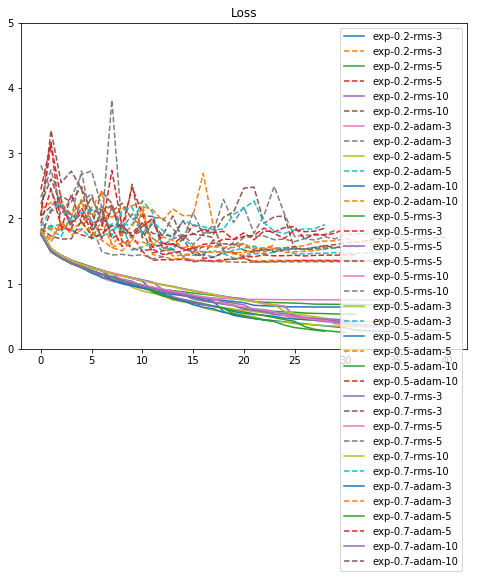

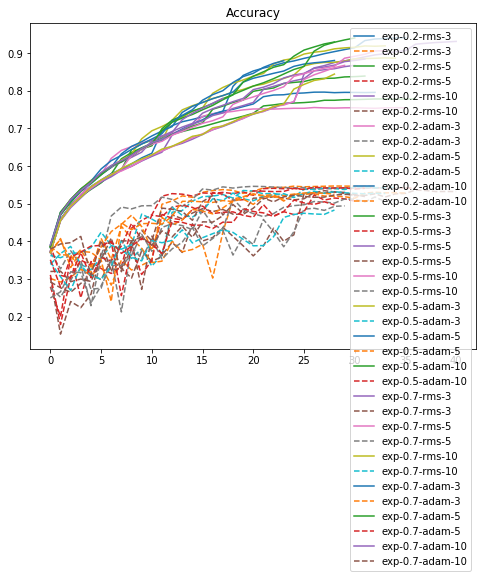

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
## color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond)
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond)
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond)
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond)
plt.title("Accuracy")
plt.legend()
plt.show()